# Fisher information applied to FPM
According to the Cramer-Rao inequality, the covariance matrix of an estimator is bounded by the inverse of the Fisher Information Matrix (FIM)

$C(\theta) \leq \bf{I}^{-1} (\theta)$



## FIM of a Poisson
$f(x|\lambda) = \frac{\lambda^{x} e^{-\lambda}}{x!}$

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift

from fpmsample.simicro import SimMicroscope, NoiseModel
from fpmsample import data, shapes
from phasemath.math import SimImage
import fpmsample.shapes as shapes

lam = 1
n=10
x = np.random.poisson(lam=lam, size=n)
# it = n*ix
ix = 1/lam
it = n/lam

So the CRLB for the estimators of $\lambda$ is $CRB(\lambda) = \mathcal{I}^{-1}(\lambda)=\lambda/n$

## Applied to an image sensor
Let's begin by implementing the fundamental model, where the only source of randomness lies in the poisson noise of the photon arrival. In this case, the information matrix is

\begin{equation}
\mathcal{I}(\theta) = \int_{t_0}^{t}\int_{\mathcal{R}^2} \frac{1}{\Lambda_{\theta}(\tau) f_{\theta, \tau}(x, y)} \left( \frac{\partial[\Lambda_\theta (\tau) f_{\theta, \tau}(x, y)]}{\partial\theta}\right)^T \left( \frac{\partial[\Lambda_\theta (\tau) f_{\theta, \tau}(x, y)]}{\partial\theta}\right) dx dy d\tau
\end{equation}

## Generating Noisy images

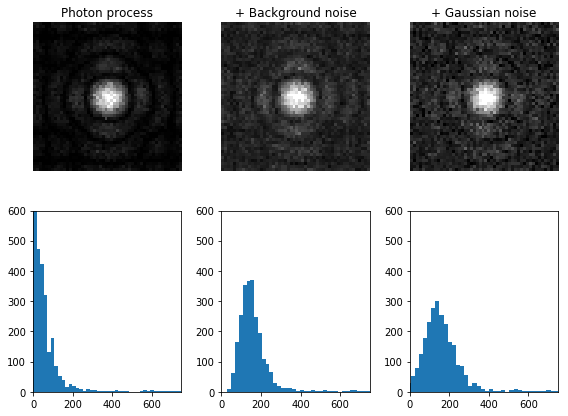

In [2]:
def cn(image_array, expossure_time=1e-1, sigmar=0, dD=0):
    gaussian_noise = np.random.normal(0, sigmar, size)
    lambdas = (np.abs(image_array)+dD)*expossure_time
    noisy_image = np.random.poisson(lam=lambdas, size=image_array.shape)+gaussian_noise
    noisy_image = noisy_image/expossure_time
    return noisy_image
size = (50, 50)
lam = 30
s = shapes.Circle(dim=50, radius=4, ft=True).draw(0, 0)*1000
cns = cn(s)
cnsd = cn(s,dD=100)
cnsdn = cn(s, dD=100,sigmar=5)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0][0].imshow(cns,  cmap='gray', vmin=0, vmax=1e3)
axes[0][0].set_title('Photon process')
axes[0][1].imshow(cnsd, cmap='gray', vmin=0, vmax=1e3)
axes[0][1].set_title('+ Background noise')
axes[0][2].imshow(cnsdn, cmap='gray', vmin=0, vmax=1e3)
axes[0][2].set_title('+ Gaussian noise')
for ax in axes[0]:
    ax.axis('off')
axes[1][0].hist(cns.ravel(), bins=60)
axes[1][1].hist(cnsd.ravel(), bins=60)
axes[1][2].hist(cnsdn.ravel(), bins=60)
for ax in axes[1]:
    ax.set_xlim([0,750])
    ax.set_ylim([0,600])
plt.tight_layout()
plt.show()

## Applied to simulated FPM images

A random harmonic combination is used as the image simulator for the FPM acquisition. 

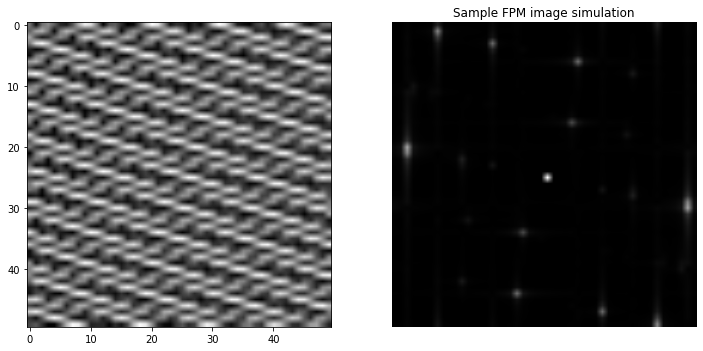

In [3]:
size = 50
simulated_image = SimImage(size=size, max_elements=2, same=True)
simimage = simulated_image.array

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(np.abs(simimage), cmap='gray', interpolation='bilinear')
axes[1].imshow(np.abs(fftshift(fft2(simimage))), cmap='gray', interpolation='bilinear')
plt.axis('off')
plt.title('Sample FPM image simulation')
plt.show()

Then, the image acquisition process is simulated with the possibility of adition of a noisy camera simulation, incorporating a Poisson process for the photon counting and background and a gaussian for the detection electronic noise.

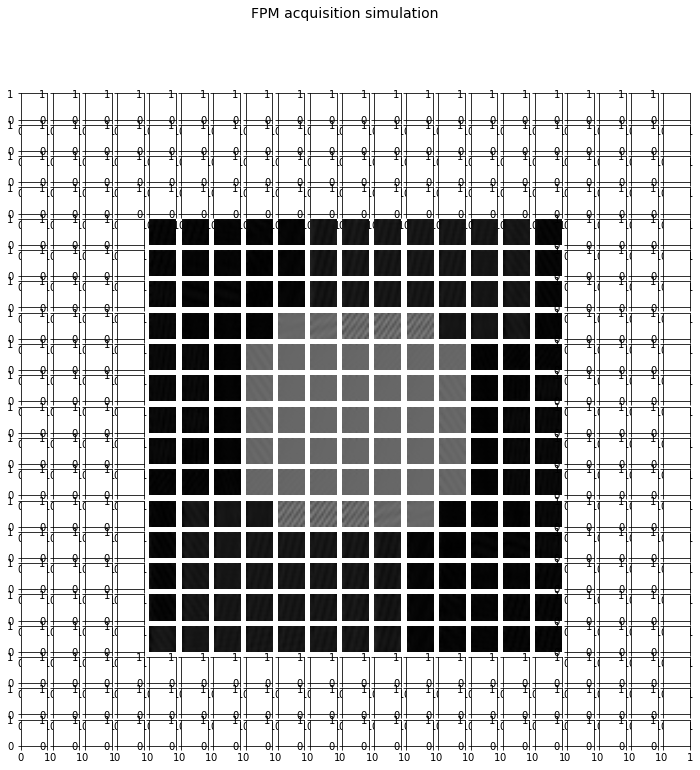

In [4]:
noise_model = NoiseModel(sigmam=[.0, .0])
cfg = data.cfg_load()
sm = SimMicroscope(noise_model=noise_model, cfg=cfg, simulated_image=simimage)
sm.generate_samples()
rm = SimMicroscope.from_dirname(dirname=sm.dirname)
delta_gk, centers = rm.get_phaseopt_input()

## Ploting the simulated captures
nl = 21
fig, axes = plt.subplots(nl, nl, figsize=(12, 12))
iterpoints = sm.iterator()

fim = np.zeros((nl, nl))
for im in delta_gk[:nl**2]:
    p = next(iterpoints)
    axy = p.yp-15+nl//2
    axx = p.xp-15+nl//2
    fim[axx, axy] = np.sum(1/im)
    axes[axx][axy].imshow(np.real(im), cmap='gray', interpolation='bilinear', vmin=0, vmax=cfg.max_photon_flux)
    axes[axx][axy].axis('off')
fig.suptitle('FPM acquisition simulation', fontsize=14)
plt.show()

## Claculating FIM for the simulated acquisition
Let's consider the first case of a Poisson process with no other source of noise than the photon arrival itself. In addition let's take the FIM for the case the only parameter $\theta$ to estimate is $\nu$, the Poisson parameter. In this simplified case, the FIM reduces to a scalar for every image $m$, and results from the addition of the inverse $\nu$ of the $K$ pixels in the image
\begin{equation}
I_m(\theta) = \sum_{k=1}^{K} \frac{1}{\nu_{\theta, k}}
\end{equation}

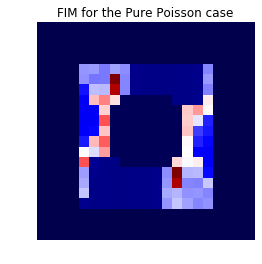

In [5]:
plt.imshow((fim), cmap='seismic')
plt.title('FIM for the Pure Poisson case')
plt.axis('off')
plt.show()

In [6]:
import pandas as pd
df_fim = pd.DataFrame(100*fim)
df_fim = df_fim.applymap('{:.1f}'.format)
df_fim

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,8.4,8.5,7.8,8.7,8.2,1.9,...,1.7,1.7,1.7,1.8,1.8,8.1,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,8.3,7.7,7.8,21.2,8.1,1.9,...,1.7,1.7,1.7,1.8,1.8,8.5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,5.7,9.2,9.2,19.1,8.1,1.9,...,1.7,1.7,1.7,1.8,1.8,8.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,5.1,12.0,13.2,11.3,0.4,0.4,...,0.4,0.4,1.7,1.8,2.0,11.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,5.0,5.1,11.6,0.4,0.4,0.4,...,0.4,0.4,0.4,11.8,12.7,10.7,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,5.0,5.1,14.2,0.4,0.4,0.4,...,0.4,0.4,0.4,11.6,10.1,6.1,0.0,0.0,0.0,0.0


## Combined Poisson and Gaussian distribution

The combination of these distributions, if independent, is the convolution of their pdfs. Assuming a poisson process 
\begin{equation}
p_l(x) = \frac{e^{-\lambda} x^l}{l!},
\end{equation}
and a gaussian distribution of the like
\begin{equation}
p_g(x) = \frac{1}{\sqrt{2\pi}\sigma_k} e^{\frac{-(x-\eta_k)^2}{2\sigma_k^2}  }
\end{equation}
la distribución de la suma $Z=L+G$ vendrá dada por
\begin{equation}
p_Z(z) = \sum p_G(z) p_L(z-g),
\end{equation}
con lo cual
\begin{equation}
pz(z) = \frac{e^{-\lambda}}{\sqrt{2 \pi} \sigma_k} \sum_{l=0}{\infty} \frac{\lambda^l}{l!} e^{\frac{-(z-l-\eta_k)^2}{2\sigma_k} }
\end{equation}

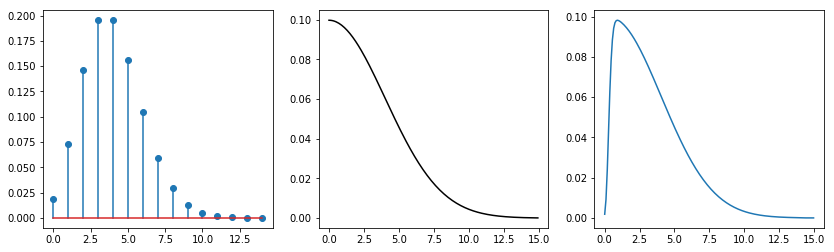

In [7]:
from scipy.stats import poisson, norm

x1 = np.arange(0,15)
lam = 4
pois = poisson.pmf(x1, lam)
x2 = np.arange(0, 15, .1)
gauss = norm.pdf(x2, 0, 4)
conv = np.convolve(pois, gauss)
fig, axes = plt.subplots(1,3, figsize=(14, 4))
axes[0].stem(pois)
axes[1].plot(x2, gauss, 'k')
axes[2].plot(np.linspace(0, 15, len(conv)), conv)
plt.show()